In [1]:
import cv2
import matplotlib.pyplot as plt
from openslide import open_slide
import os
import sys
sys.path.insert(0,'..')
import utils
from skimage.color import rgb2gray
import numpy as np
from tqdm.notebook import tqdm

In [2]:
slide = open_slide("../TIFs/trainingTIFs/tumor_031.tif")

In [3]:
slide_image = utils.read_slide(slide, 0, 0, 3, slide.level_dimensions[3][0], slide.level_dimensions[3][1])
slide_image_gray = rgb2gray(slide_image)

In [4]:
slide_image_gray.shape

(27648, 12224)

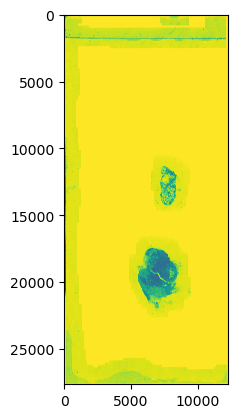

In [5]:
plt.imshow(slide_image_gray)

In [ ]:
tissue_mask = utils.find_tissue_pixels(slide_image)
masked = utils.apply_mask(slide_image, tissue_mask)

In [ ]:
slide_image.shape

In [ ]:
masked.shape

In [ ]:
plt.imshow(masked)

In [ ]:
mask = open_slide("../TIFs/trainingTIFs/tumor_091_mask.tif")
mask_image = utils.read_slide(mask, 0, 0, 4, mask.level_dimensions[4][0], slide.level_dimensions[4][1])[:,:,0]

In [ ]:
mask_image.shape

In [ ]:
a = np.transpose(np.where(mask_image == 1))
a

In [ ]:
len(a)

In [ ]:
slide_image.shape

In [ ]:
def contruct_normal_truth_array(slide_image, mask_image, input_size):
    """
    Args:
        slice_image: RGB
        mask_image: 2D
    """
    slice_gray = rgb2gray(slide_image)
    h, w = slice_gray.shape
    res = np.zeros((h, w))
    for i in tqdm(range(h)):
        for j in tqdm(range(w), leave=False):
            i_start = i - input_size // 2
            i_end = i_start + input_size
            j_start = j - input_size // 2
            j_end = j_start + input_size
            region = extract_region(j, i, mask_image)
            # if not tissue
            if slice_gray[i][j] > 0.8:
                res[i][j] = False
            # if out of bound
            elif i_start < 0 or j_start < 0:
                res[i][j] = False
            elif i_end > h or j_end > w:
                res[i][j] = False
            elif np.count_nonzero(region) == 0:
                res[i][j] = True
            else:
                res[i][j] = False
    return res

In [ ]:
%%time
normal_res = contruct_normal_truth_array(slide_image, mask_image, 299)

In [ ]:
plt.imshow(mask_image)

In [ ]:
def extract_region(x, y, image):
    """x, y w.r.t computer vision"""
    x_start = x - 299 // 2
    y_start = y - 299 // 2
    return image[y_start:y_start+299, x_start:x_start+299]

In [ ]:
slide.level_dimensions

In [ ]:
((7680 - 299) / 50) * ((6720 - 299) / 50)

Idea
1. 

In [ ]:
def contains_enough_tissue(slide_im, input_size, threshold, intensity=0.8):
    """transform array into truthful array
    where for each element, return True 
    if a region of size (input_size, input_size) 
    centered at this element contains at least
    threshold proportion of tissue cells
    
    Args:
        slide_im: 3D RGB array
        
    Conditions:
        1. region size is valid
        2. contains enough tissue
    """
    # 3D -> 2D
    slide_im_gray = rgb2gray(slide_im)
    res = np.zeros((slide_im_gray.shape[0], slide_im_gray.shape[1]))
    for i in tqdm(range(slide_im_gray.shape[0])):
        for j in tqdm(range(slide_im_gray.shape[1]), leave=False):
            i_start = i - input_size // 2
            i_end = i_start + input_size
            j_start = j - input_size // 2
            j_end = j_start + input_size
            # 1. satisfy the first condition
            if i_start > 0 and j_start > 0 and i_end < slide_im_gray.shape[0] and j_end < slide_im_gray.shape[1]:
                region = slide_im_gray[i_start:i_end, j_start:j_end]
                is_tissue = region <= intensity
                # satisfy the 2nd condition
                # check percentage is a very expensive operation
                # instead, let's try some heuristics
                if np.count_nonzero(is_tissue) / (input_size * input_size) >= threshold:
                    res[i][j] = True
                else:
                    res[i][j] = False
            else:
                res[i][j] = False
    return res

In [ ]:
# res = contains_enough_tissue(slide_image, 299, 0.4, intensity=0.8)

In [ ]:
test = np.load("test.npy")
test.shape

In [1]:
# def customf(x, y):
#     return {
#         "input1": utils.read_slide(slide, x[0], x[1], down_level1, input_shape, input_shape),
#         "input2": utils.read_slide(slide, y[0], y[1], down_level2, input_shape, input_shape)
#     }

# a_ds = tf.data.Dataset.from_tensor_slices((zoom1_xy, zoom2_xy))
# a_ds = a_ds.map(
#     lambda x, y: tf.numpy_function(func=customf, inp={"input1":x, "input2":y}, Tout=(tf.uint8, tf.uint8)),
#     num_parallel_calls=tf.data.AUTOTUNE
# )
# a_ds = a_ds.batch(batch_size)
# a_ds = a_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# for i, j in a_ds:
#     print(i.shape)
#     print(j.shape)
#     break

In [ ]:
# def generator():
#     for x in zip(((zoom1_xy_ds, zoom2_xy_ds),)):
#         yield x 

In [ ]:
# test_ds = tf.data.Dataset.from_generator(
#     generator, 
#     output_signature=(
#         tf.TensorSpec(shape=(299,299,3), dtype=tf.uint8), 
#         tf.TensorSpec(shape=(299,299,3), dtype=tf.uint8)
#     )
# )
# test_ds = test_ds.batch(batch_size)
# test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [2]:
# w, h = slide.level_dimensions[cur_level] # pay attention to the order
# predicted_mask = np.zeros((h, w))
# for cur_ij, images in tqdm(test_ds):
#     patch1, patch2 = images[0], images[1]
#     y_pred = model.predict_on_batch([patch1, patch2]).flatten()
#     one_idx = np.where(y_pred == 1)
#     indices_to_set = tf.gather(cur_ij, one_idx).numpy()
#     # set those indices to 1
#     predicted_mask[tuple(indices_to_set.T)] = 1